<a href="https://colab.research.google.com/github/aquangnguyen1992/tensorflow_colab/blob/max_detection_mnist/MNIST_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Check the Tensorflow version and load the dataset***

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.2.0'

In [2]:
#import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras import Model

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
NUMBER_OF_DATA = x_train.shape[0]
x_train = x_train[..., tf.newaxis]

train_val_split = 0.8

x_val = x_train[int(NUMBER_OF_DATA*train_val_split):,:,:,:]
x_train = x_train[:int(NUMBER_OF_DATA*train_val_split),:,:,:]

y_val = y_train[int(NUMBER_OF_DATA*train_val_split):]
y_train = y_train[:int(NUMBER_OF_DATA*train_val_split)]

x_test = x_test[..., tf.newaxis]

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape)

11493376/11490434 [==============================] - 0s 0us/step
(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1) (48000,) (12000,)


6


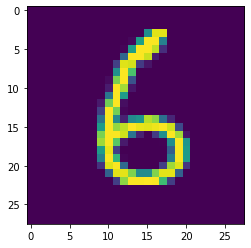

In [3]:
i = np.random.randint(0, x_train.shape[0])
image_to_display = x_train[i]
image_to_display = image_to_display.reshape([28, 28]).astype('float32')
print(y_train[i])
plt.imshow(image_to_display)

# ***Design the NN***

In [4]:
'''W = tf.Variable(tf.zeros(shape=(28*28,10), name="W"))
b = tf.Variable(tf.ones(shape=(10)), name="bias")

@tf.function
def forward(X):
  return tf.nn.softmax(W*X+b)

y_prediction = forward(image_to_display.reshape([28*28,1]))
print(y_prediction)


one_hot = tf.one_hot(label, depth=10)
#cross_entropy = lambda: tf.reduce_mean(-tf.reduce_sum(one_hot*tf.math.log(y_prediction)))
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
#train_step = opt.minimize(cross_entropy, [one_hot, y_prediction]).numpy()

@tf.function
def train_step(inputs, labels):
  with tf.GradientTape() as tape:
    predictions = forward(inputs)
    regularization_loss=tf.math.add_n(model.losses)
    pred_loss=loss_fn(labels, predictions)
    total_loss=pred_loss + regularization_loss

  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))'''


'W = tf.Variable(tf.zeros(shape=(28*28,10), name="W"))\nb = tf.Variable(tf.ones(shape=(10)), name="bias")\n\n@tf.function\ndef forward(X):\n  return tf.nn.softmax(W*X+b)\n\ny_prediction = forward(image_to_display.reshape([28*28,1]))\nprint(y_prediction)\n\n\none_hot = tf.one_hot(label, depth=10)\n#cross_entropy = lambda: tf.reduce_mean(-tf.reduce_sum(one_hot*tf.math.log(y_prediction)))\nloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)\nopt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)\n#train_step = opt.minimize(cross_entropy, [one_hot, y_prediction]).numpy()\n\n@tf.function\ndef train_step(inputs, labels):\n  with tf.GradientTape() as tape:\n    predictions = forward(inputs)\n    regularization_loss=tf.math.add_n(model.losses)\n    pred_loss=loss_fn(labels, predictions)\n    total_loss=pred_loss + regularization_loss\n\n  gradients = tape.gradient(total_loss, model.trainable_variables)\n  optimizer.apply_gradients(zip(gradients, model.trainable_variable

In [7]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [8]:
class MyModel(Model):
  def __init__(self, conv1=32, dense1=64, dropout=0.3, regular_l1=0.01, regular_l2=0.01):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(conv1, 3, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l1(regular_l1),
                        activity_regularizer=tf.keras.regularizers.l2(regular_l2))
    self.flatten = Flatten()
    self.Dropout = Dropout(dropout)
    self.BatchNormalization = BatchNormalization()
    self.d1 = Dense(dense1, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l1(regular_l1),
                        activity_regularizer=tf.keras.regularizers.l2(regular_l2))
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.Dropout(x)
    x = self.BatchNormalization(x)
    x = self.d1(x)
    x = self.Dropout(x)
    return self.d2(x)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Create an instance of the model
model = MyModel(conv1=32, dense1=128)

In [9]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  val_loss(t_loss)
  val_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [10]:
EPOCHS = 10

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  #test_loss.reset_states()
  #test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)

  #for test_images, test_labels in test_ds:
  #  test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.21634891629219055, Accuracy: 93.69583129882812, Val Loss: 0.08069421350955963, Val Accuracy: 97.75
Epoch 2, Loss: 0.10026095807552338, Accuracy: 96.93541717529297, Val Loss: 0.08193090558052063, Val Accuracy: 97.54166412353516
Epoch 3, Loss: 0.07912591099739075, Accuracy: 97.59375, Val Loss: 0.09407536685466766, Val Accuracy: 97.92500305175781
Epoch 4, Loss: 0.06818640232086182, Accuracy: 97.88542175292969, Val Loss: 0.09483703970909119, Val Accuracy: 98.14166259765625
Epoch 5, Loss: 0.

In [11]:
for test_images, test_labels in test_ds:
  test_step(test_images, test_labels)

template = 'Test Loss: {}, Test Accuracy: {}'
print(template.format(test_loss.result(),
                      test_accuracy.result() * 100))

Test Loss: 0.1337549239397049, Test Accuracy: 98.19999694824219


# ***MNIST max using images***

(1733, 28, 28, 3) (1733, 1)


(array([  2.,  17.,  41.,  71., 121., 178., 274., 347., 682.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

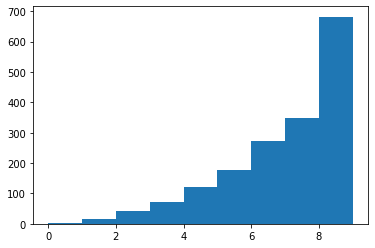

In [122]:
# Create the dataset
train_size = 2000
test_size = 200

def data_generation(data_size):
  x = None
  y = None
  drop_this = False
  for i in range(data_size):
    i = np.random.randint(0, x_train.shape[0], size=(3,1))
    selected_images = x_train[i]
    selected_images = np.squeeze(selected_images, axis=(1,4))
    selected_images = np.moveaxis(selected_images, 0, 2)
    selected_images = np.expand_dims(selected_images, axis=0)

    max_value = np.array([np.max(y_train[i])])
    max_value = np.expand_dims(max_value, axis=0)
    if max_value == 9:
      if drop_this:
        drop_this = False
        continue      
      else:
        drop_this = True

    if x is None:    
      x = selected_images
      y = max_value
    else:
      x = np.concatenate((x, selected_images), axis=0)    
      y = np.concatenate((y, max_value), axis=0) 
  return x,y

x_max_train, y_max_train = data_generation(train_size)
x_max_test, y_max_test = data_generation(test_size)

print(x_max_train.shape, y_max_train.shape)
plt.hist(y_max_train, bins=range(10))

[9]


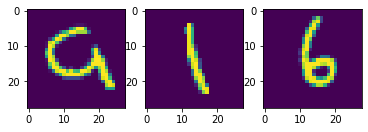

In [123]:
i = np.random.randint(0, x_max_train.shape[0])

test_label = y_max_train[i]

for j in range(3):
  test_im = x_max_train[i,:,:,j]
  plt.subplot(1,3,j+1)
  plt.imshow(test_im)

print(test_label)


In [124]:
# Create the model Keras-style
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD

def create_model(conv_layer1=32, conv_layer2=32, dense_node=128, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001):
  out_model = Sequential()
  out_model.add(Conv2D(conv_layer1, kernel_size=(3,3), strides=(2,2), 
                       input_shape=(x_max_train.shape[1], x_max_train.shape[2], x_max_train.shape[3]),
                       activation="relu", 
                       kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                       activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Flatten())
  out_model.add(BatchNormalization())
  out_model.add(Dropout(dropout_rate))
  out_model.add(Dense(dense_node, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(Dense(np.max(y_max_train)+1, activation="softmax"))

  out_model.compile(
            optimizer=Adam(learning_rate=0.0003),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
  
  return out_model

In [136]:
my_model = create_model(conv_layer1=8, dense_node=16, dropout_rate=0.5, l2_rate=0.005)
my_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 13, 13, 8)         224       
_________________________________________________________________
flatten_17 (Flatten)         (None, 1352)              0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 1352)              5408      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1352)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                21648     
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)              

In [137]:
BATCH_SIZE = 16
NB_EPOCH = 100

history = my_model.fit(x_max_train, y_max_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True)

Epoch 1/100
87/87 [==============================] - 1s 6ms/step - loss: 3.8631 - sparse_categorical_accuracy: 0.1479 - val_loss: 3.0652 - val_sparse_categorical_accuracy: 0.1902
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 3.4996 - sparse_categorical_accuracy: 0.1580 - val_loss: 2.9578 - val_sparse_categorical_accuracy: 0.2507
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 3.1584 - sparse_categorical_accuracy: 0.1941 - val_loss: 2.8775 - val_sparse_categorical_accuracy: 0.2709
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 2.9818 - sparse_categorical_accuracy: 0.2201 - val_loss: 2.8063 - val_sparse_categorical_accuracy: 0.2767
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 2.8389 - sparse_categorical_accuracy: 0.2475 - val_loss: 2.7302 - val_sparse_categorical_accuracy: 0.2853
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 2.7618 - sparse_categorical_accu

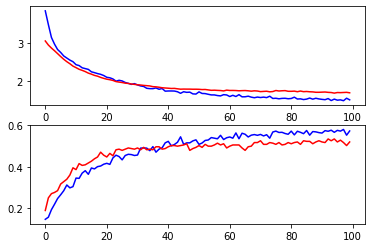

In [138]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["sparse_categorical_accuracy"], '-b')
plt.plot(history.history["val_sparse_categorical_accuracy"], '-r')

In [139]:
my_model.evaluate(x_max_test, y_max_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.6473 - sparse_categorical_accuracy: 0.5143


[1.6473256349563599, 0.5142857432365417]

In [152]:
i = np.random.randint(0, x_max_test.shape[0])
predicted = np.argmax(my_model.predict(np.expand_dims(x_max_test[i], axis=0)))
print(predicted, y_max_test[i])

8 [8]
